In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)



Last day in Measurement table: 2017-08-23



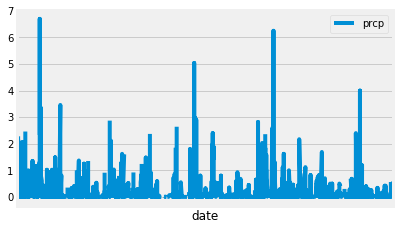

In [3]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_row = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"\n\nLast day in Measurement table: {last_row[0]}\n")

# Perform a query to retrieve the data and precipitation scores
last_12months = session.query(Measurement.date, Measurement.prcp).filter(func.strftime("%Y-%m-%d", Measurement.date) >= "2016-08-23").all() 

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_df = pd.DataFrame(last_12months, columns = ['date', 'prcp'])
last_year_df['date'] = pd.to_datetime(last_year_df['date'])
last_year_df = last_year_df.set_index(['date']).sort_index(ascending=True)

last_year_df.plot(rot=90, xticks = [])
plt.show()

In [4]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [5]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.id).count()
print(f"There are {stations} stations.")

There are 9 stations.


In [6]:
# List the stations and the id counts in descending order.
station_counts = session.query(Measurement.station, Measurement.id).all()
station_counts_df = pd.DataFrame(station_counts)
station_counts_df = station_counts_df.groupby('station').count().sort_values(by=['id'], ascending=False)
print(station_counts_df)

               id
station          
USC00519281  2772
USC00519397  2724
USC00513117  2709
USC00519523  2669
USC00516128  2612
USC00514830  2202
USC00511918  1979
USC00517948  1372
USC00518838   511


In [7]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
temp1 = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281')
temp_df1 = pd.DataFrame(temp1)
lowtemp = temp_df1.min()
hightemp = temp_df1.max()
avgtemp = temp_df1.mean()

print(f"\n\nUSC00519281 Temperature Observation Stats:\n\nLow: {float(lowtemp)}F\nHigh: {float(hightemp)}F\nAverage: {float(round(avgtemp,1))}F\n\n")



USC00519281 Temperature Observation Stats:

Low: 54.0F
High: 85.0F
Average: 71.7F




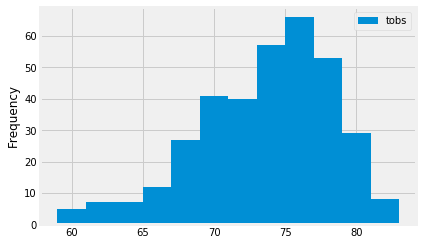

In [8]:
# Query the last 12 months of temperature observation data for USC00519281 and plot the results as a histogram
temp2 = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(func.strftime("%Y-%m-%d", Measurement.date) >= "2016-08-23")
temp_df2 = pd.DataFrame(temp2)
temp_df2.plot(kind='hist', bins = 12)
plt.show()

Don't know how to get flask to run in notebook. Please run .py script to see API

In [10]:
from flask import Flask, jsonify
import statistics as stat

#Creating an app, being sure to pass __name__
app = Flask(__name__)

#Home
@app.route("/")
def welcome():
    return (
        f"Welcome to Station Observatioin API!<br/>"
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/&ltstart&gt<br/>"
        f"/api/v1.0/&ltstart&gt/&ltend&gt<br/>"
     
    )


#Define route and output json for precipitation request
@app.route("/api/v1.0/precipitation")
def prec():

    return jsonify(dict(last_12months))

#Define route and output json for stations list request
@app.route("/api/v1.0/stations")
def stations():

    return jsonify({"stations":list(station_counts_df.index)})

#Define route and output json for tobs request
@app.route("/api/v1.0/tobs")
def tobs():
    
    session = Session(engine)
    temp3 = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(func.strftime("%Y-%m-%d", Measurement.date) >= "2016-08-23")
    
    return jsonify(dict(temp3))

#Define route and output json for tobs request with start date
@app.route("/api/v1.0/<start>")
def tobs_start(start):
    start = str(start)
    session = Session(engine)
    temp4 = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%Y-%m-%d", Measurement.date) >= start)
    TMAX = max(list(zip(*temp4))[1])
    TMIN = min(list(zip(*temp4))[1])
    TAVG = round(stat.mean(list(zip(*temp4))[1]),2)
    
    return jsonify({"Stats": [TMAX, TMIN, TAVG]})

#Define route and output json for tobs request with start and end date
@app.route("/api/v1.0/<start>/<end>")
def tobs_start_end(start,end):
    start = str(start)
    end = str(end)
    session = Session(engine)
    temp5 = session.query(Measurement.date, Measurement.tobs).filter(func.strftime("%Y-%m-%d", Measurement.date) >= start).filter(func.strftime("%Y-%m-%d", Measurement.date) <= end)
    TMAX = max(list(zip(*temp5))[1])
    TMIN = min(list(zip(*temp5))[1])
    TAVG = round(stat.mean(list(zip(*temp5))[1]),2)
    
    return jsonify({"Stats": [TMAX, TMIN, TAVG]})

if __name__ == "__main__":
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


OSError: [Errno 48] Address already in use